In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# Question 2

In [2]:
detection = pd.read_excel('detections.xlsx').sort_values(by='score', ascending=False)
ground_truth = pd.read_excel('ground-truth.xlsx')

In [3]:
detection

,x,y,w,h,score
3,114,31,14,21,0.96
2,55,72,34,36,0.89
0,11,5,19,26,0.84
1,18,39,31,23,0.79
6,124,136,29,35,0.74
4,24,98,21,34,0.47
5,36,150,41,26,0.39
7,92,153,27,47,0.29


In [4]:
class Rect:
    def __init__(self, x, y, w, h):
        self.x1 = int(x)
        self.x2 = int(x + w)
        self.y1 = int(y)
        self.y2 = int(y + h)
    
    def __getitem__(self):
        return self.x1, self.y1, self.x2, self.y2
    
class Region(Rect):
    def __init__(self, x, y, w, h, score = 0):
        Rect.__init__(self, x, y, w, h)
        self.score = score
    def __getscore__(self):
        return self.score

In [5]:
def IoU(rec1, rec2):
    
    rec1_x1, rec1_y1, rec1_x2, rec1_y2 = rec1.__getitem__()
    rec2_x1, rec2_y1, rec2_x2, rec2_y2 = rec2.__getitem__()
    
    height = max(rec1_y1, rec1_y2, rec2_y1, rec2_y2)
    width = max(rec1_x1, rec1_x2, rec2_x1, rec2_x2)
    
    label = np.zeros((height, width))
    
    label[rec1_y1:rec1_y2 + 1, rec1_x1: rec1_x2 + 1] = label[rec1_y1:rec1_y2 + 1, rec1_x1: rec1_x2 + 1] + 1
    label[rec2_y1:rec2_y2 + 1, rec2_x1: rec2_x2 + 1] = label[rec2_y1:rec2_y2 + 1, rec2_x1: rec2_x2 + 1] + 1
    
    intersect = len(label[np.where(label == 2)])
    union = len(label[np.where(label >= 1)])
    
    return intersect/union 

In [6]:
rect_func = lambda obj: Rect(obj[1][0], obj[1][1], obj[1][2], obj[1][3])
region_func = lambda obj: Region(obj[1][0], obj[1][1], obj[1][2], obj[1][3], obj[1][4])

detected = []
region = []

for obj in ground_truth.iterrows():   
    region.append(rect_func(obj))
    
for obj in detection.iterrows():   
    detected.append(region_func(obj))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


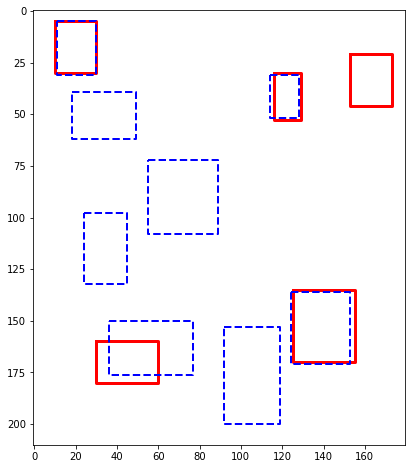

In [7]:
image = np.ones((180,180,3)) * 255

plt.figure(figsize=(8,8))
plt.imshow(image)

for obj in region:
    x1, y1, x2, y2 = obj.__getitem__()
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r', lw=3)
    
for obj in detected:
    x1, y1, x2, y2 = obj.__getitem__()
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'b', ls='--', lw=2)
    
plt.show()

In [8]:
def AP(threshold, region, detected):
    
    ious = []
    for rect in detected:
        for reg in region:
            iou = IoU(rect, reg)
            
            ious.append(iou)
      
        
    ious = np.array(ious)
            
    tp = len(ious[ious > threshold])
    fn = len(detected) - tp
    fp = len(region) - tp
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    return np.mean(precision)

In [9]:
print("AP-75 : ", AP(0.75, region, detected))
print("AP-50 : ", AP(0.50, region, detected))
print("AP-25 : ", AP(0.25, region, detected))

AP-75 :  0.6
AP-50 :  0.6
AP-25 :  0.8


# Question 4

<Figure size 720x288 with 0 Axes>

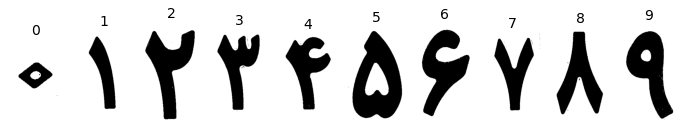

In [10]:
template = [cv2.threshold(cv2.imread('Templates/{}.jpg'.format(x), 0), 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] for x in range(10)]
plates = [cv2.imread('Plates/Plate{}.jpg'.format(x), 0) for x in range(1,10)]

plt.figure(figsize=(10,4))


plt.figure(figsize=(12,4))
for i, img in enumerate(template):
    (_, img) = cv2.threshold(template[i], 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    

for i in range(10):
    img = template[i]
    
    plt.subplot(1,10, i+1)
    plt.imshow(img, 'gray'), plt.axis('off'), plt.title(i, size=14)

plt.show()

# Plates image pre-processing

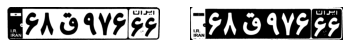

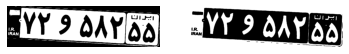

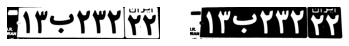

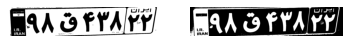

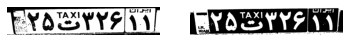

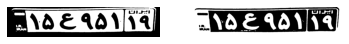

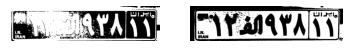

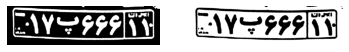

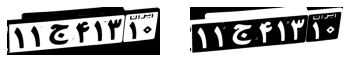

In [11]:
plates_adj = dict()

for i in range(9):
    h, w = plates[i].shape
    
    img = cv2.resize(plates[i], (w*350//h, 350))
    
    img1, img2 = img, 255 - img

    (_, img1) = cv2.threshold(img1, 90, 150, cv2.THRESH_BINARY)
    (_, img2) = cv2.threshold(img2, 150, 200, cv2.THRESH_BINARY)

    kernel_1 = np.ones((3,1))
    kernel_2 = np.ones((3,3))

    img1 = cv2.dilate(img1, kernel_1)
    img1 = cv2.erode(img1, kernel_2)

    img2 = cv2.dilate(img2, kernel_1)
    img2 = cv2.erode(img2, kernel_2)

    
    plates_adj[i] = [img1, img2]

    plt.subplot(1,2,1)
    plt.imshow(img1, 'gray'), plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img2, 'gray'), plt.axis('off')

    plt.show()

# Template pre-processing

In [13]:
import imutils

rotation_angles = np.arange(-20, 21, 10)
scale_percents = np.arange(-30, 31, 15)

threshold = 0.7

template_adj = dict()

for i, temp in enumerate(template):
    template_list = []
    for scale in scale_percents:
        h, w = temp.shape
        img = cv2.resize(temp, (h * (100 + scale)//100, w * (100 + scale)//100))
        
    
        for angle  in rotation_angles:
            tem  = imutils.rotate(255 - img, angle)
            template_list.append(255 - tem)

    template_adj[i] = template_list

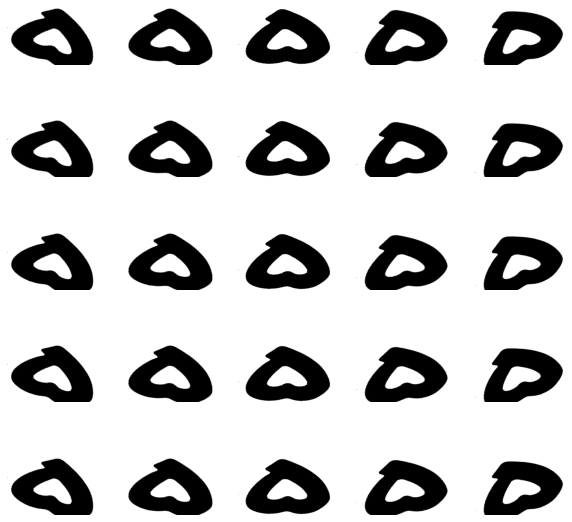

In [14]:
plt.figure(figsize=(10,10))
for i, temp in enumerate(template_adj[5]):
    plt.subplot(5, 5, i+1)
    plt.imshow(temp, 'gray'), plt.axis('off')
    
plt.show()

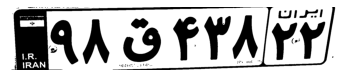

[]


In [15]:

img = np.copy(plates_adj[3][0])
num = []
for i, temp__ in template_adj.items():
    for temp in temp__:
        h, w = temp.shape
        
        if h >= img.shape[0]:
            break
            
        res = cv2.matchTemplate(img,temp,cv2.TM_CCOEFF_NORMED)
        threshold = 0.6
        loc = np.where( res >= threshold)
    
        for pt in zip(*loc):
            cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
                
        plt.imshow(img, 'gray'), plt.axis('off')
plt.show()

print(num)